# First you need to set the runtime to one with GPU,it can be set in the notebook settings

### Initial Dependences
### And remove pre-installed items

In [ ]:
%pip install --upgrade pip
%pip uninstall -y tensorflow numba
%pip install matplotlib\
numpy==1.19.3 \
inflect==0.2.5 \
librosa==0.6.0 \
Unidecode==1.0.22 \
pillow
%pip install janome==0.4.2
# %pip install scipy==1.0.0 
%pip install denoiser==0.1.0
%pip install librosa==0.8.0
%pip install numba
%pip install pysoundfile==0.9.0.post1
%pip install unidecode==1.3.4
%pip install pyopenjtalk==0.2.0
%pip install inflect==5.6.2
%pip install janome==0.4.2



### Clone Repository and Copy files


In [ ]:
!git clone https://github.com/CjangCjengh/tacotron2-japanese.git
!cp -r /content/tacotron2-japanese/* /content

### Import models from Google Drive
## BE AWARE OF THE POP-UP WINDOW BY GOOGLE
files at : [HERE](https://drive.google.com/drive/folders/1ql2jv4JTL7klWXQTMSnJmrMNMc1aRU5Q?usp=sharing)
### Then copy items from Gdrive
### Or you can manually upload module files to /content if you dont want to import files via GDrive
### If doing that, you should also change the filename in the load checkpoint cell

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp -r /content/gdrive/MyDrive/tacotron2-japanese/* /content

#### Import libraries and setup matplotlib

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from waveglow.denoiser import Denoiser

In [ ]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')

#### Setup hparams

In [ ]:
hparams = create_hparams()
hparams.sampling_rate = 22050

#### Load model from checkpoint

In [ ]:
checkpoint_path = "ayachi_nene_1"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval()#.half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [ ]:
waveglow_path = 'waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval()#.half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

#### Prepare text input

In [ ]:
text = "こんにちは。"
sequence = np.array(text_to_sequence(text, ['japanese_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

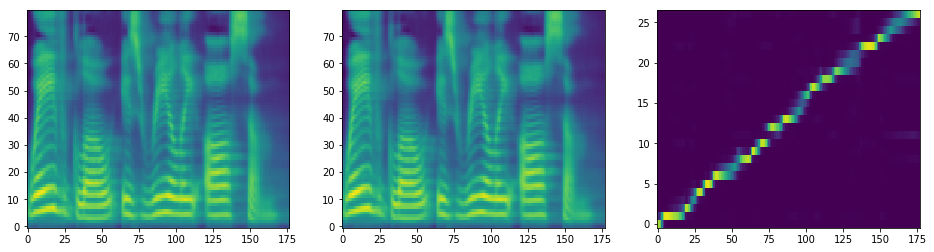

In [ ]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [ ]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#### (Optional) Remove WaveGlow bias

In [ ]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 